<a href="https://colab.research.google.com/github/SammyGbabs/FaunaPulse-Capstone-Project/blob/main/Dataset_Labelling_(Using_the_Automatic_threshold_and_Unsupervised_Learning)_with_optimal_k%3D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount drive for me

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Merging the files inside the folders.
import os
import shutil

# Define the paths
source_parent_dir = '/content/drive/MyDrive/Freq_shifted'
burnt_dir = os.path.join(source_parent_dir, 'Burnt')
unburnt_dir = os.path.join(source_parent_dir, 'Unburnt')
destination_dir = os.path.join(source_parent_dir, 'data')

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Function to copy files
def copy_files(source_dir, destination_dir):
    if os.path.exists(source_dir):
        for filename in os.listdir(source_dir):
            source_file = os.path.join(source_dir, filename)
            destination_file = os.path.join(destination_dir, filename)
            # Copy the file, overwriting if it exists
            shutil.copy2(source_file, destination_file)
            print(f"Copied: {filename}")
    else:
        print(f"Source directory does not exist: {source_dir}")


# Copy files from 'burnt' to 'data'
print("Copying files from 'burnt'...")
copy_files(burnt_dir, destination_dir)

# Copy files from 'unburnt' to 'data'
print("\nCopying files from 'unburnt'...")
copy_files(unburnt_dir, destination_dir)

print("\nMerge complete.")


Copying files from 'burnt'...
Copied: B260T1_Clean_Left_221126-122401-480_540.wav
Copied: B260T1_Clean_Left_221126-122401-360_420.wav
Copied: B260T1_Clean_Left_221126-122401-240_300.wav
Copied: B260T1_Clean_Left_221126-122401-180_240.wav
Copied: B260T1_Clean_Left_221126-122401-60_120.wav
Copied: B260T1_Clean_Left_221126-122401-120_180.wav
Copied: B260T1_Clean_Left_221126-122401-0_60.wav
Copied: B260T1_Clean_Left_221126-122401-420_480.wav
Copied: B260T1_Clean_Left_221126-122401-300_360.wav
Copied: B260T1_Clean_Left_221126-122401-840_900.wav
Copied: B260T1_Clean_Left_221126-122401-1080_1140.wav
Copied: B260T1_Clean_Left_221126-122401-780_840.wav
Copied: B260T1_Clean_Left_221126-122401-1020_1080.wav
Copied: B260T1_Clean_Left_221126-122401-660_720.wav
Copied: B260T1_Clean_Left_221126-122401-720_780.wav
Copied: B260T1_Clean_Left_221126-122401-540_600.wav
Copied: B260T1_Clean_Left_221126-122401-960_1020.wav
Copied: B260T1_Clean_Left_221126-122401-600_660.wav
Copied: B260T1_Clean_Left_221126-

In [ ]:
import os, csv
import numpy as np
import librosa
from scipy.stats import entropy
from librosa import onset

audio_dir = '/content/drive/MyDrive/Freq_shifted/data'
out_csv   = '/content/drive/MyDrive/Freq_shifted/data/features_extended.csv'

def spectral_entropy(S):
    # Normalize spectrogram to a probability distribution over frequency bins
    p = S / np.sum(S, axis=0, keepdims=True)
    # Compute entropy for each frame, then average
    ent = entropy(p, base=2, axis=0)
    return np.mean(ent)

def bioacoustic_index(S, sr, fmin=2000, fmax=8000):
    # Sum energy in the biologically relevant band
    freqs = librosa.fft_frequencies(sr=sr)
    idx = np.where((freqs >= fmin) & (freqs <= fmax))
    return np.sum(S[idx, :])

def ndsi(S, sr, bio_band=(2000, 8000), anthro_band=(100, 1000)):
    freqs = librosa.fft_frequencies(sr=sr)
    S_bio    = np.sum(S[(freqs >= bio_band[0]) & (freqs <= bio_band[1]), :])
    S_anthro = np.sum(S[(freqs >= anthro_band[0]) & (freqs <= anthro_band[1]), :])
    # avoid divide by zero
    if (S_bio + S_anthro) == 0:
        return 0
    return (S_bio - S_anthro) / (S_bio + S_anthro)

def event_density(y, sr, hop_length=512):
    # Use onset detection to count “events”
    o_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr, hop_length=hop_length)
    return len(onset_frames) / (len(y)/sr)  # events per second

with open(out_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    header = [
        'filename', 'rms', 'spectral_entropy', 'bioacoustic_index',
        'ndsi', 'event_density'
    ] + [f'mfcc{i}' for i in range(1,14)]
    writer.writerow(header)

    for fn in os.listdir(audio_dir):
        path = os.path.join(audio_dir, fn)
        if not os.path.isfile(path) or not fn.lower().endswith(('.wav','.mp3','.flac','.ogg')):
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            # Compute STFT magnitude once
            S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))

            # Compute indices
            rms_val      = librosa.feature.rms(y=y).mean()
            ent_val      = spectral_entropy(S)
            bi_val       = bioacoustic_index(S, sr)
            ndsi_val     = ndsi(S, sr)
            evt_density  = event_density(y, sr)
            mfcc_vals    = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)

            writer.writerow([
                fn, rms_val, ent_val, bi_val,
                ndsi_val, evt_density, *mfcc_vals
            ])
        except Exception as e:
            print(f"Error processing {fn}: {e}")

['filename', 'rms', 'spectral_entropy', 'bioacoustic_index', 'ndsi', 'event_density', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13']


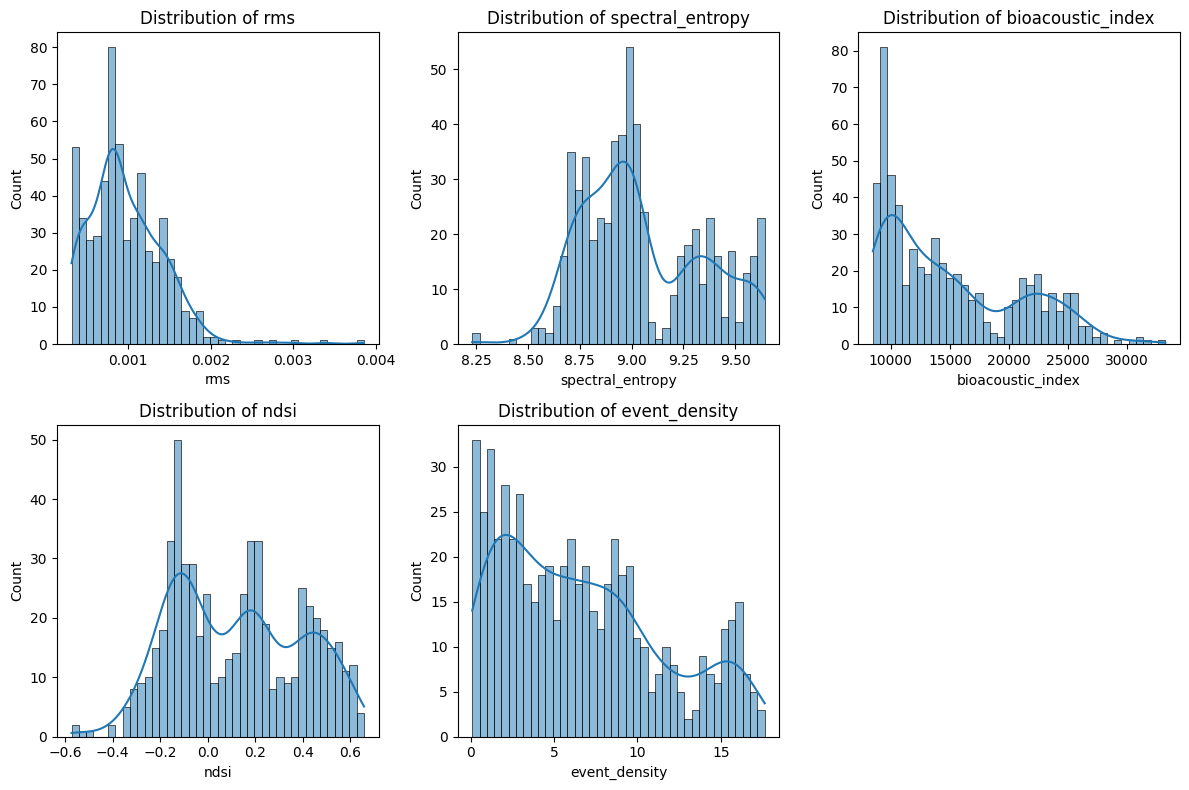

An error occurred during download: stat: path should be string, bytes, os.PathLike or integer, not DataFrame


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Load the features CSV you generated in Step 1
df = pd.read_csv('/content/drive/MyDrive/Freq_shifted/data/features_extended.csv')

# Inspect the columns
print(df.columns.tolist())
# Expect something like: ['filename','rms','spectral_entropy','bioacoustic_index','ndsi','event_density','mfcc1',...,'mfcc13']

# Plot histograms for key metrics
metrics = ['rms','spectral_entropy','bioacoustic_index','ndsi','event_density']
plt.figure(figsize=(12, 8))

for i, m in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[m], bins=40, kde=True)
    plt.title(f'Distribution of {m}')
    plt.xlabel(m)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Path to the features.csv file
features_csv_path = "/content/drive/MyDrive/Freq_shifted/data/features_extended.csv"

try:
  files.download(df)
  print(f"'{features_csv_path}' downloaded successfully.")
except FileNotFoundError:
  print(f"Error: The file '{features_csv_path}' was not found.")
except Exception as e:
  print(f"An error occurred during download: {e}")


['filename', 'rms', 'spectral_entropy', 'bioacoustic_index', 'ndsi', 'event_density', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13']


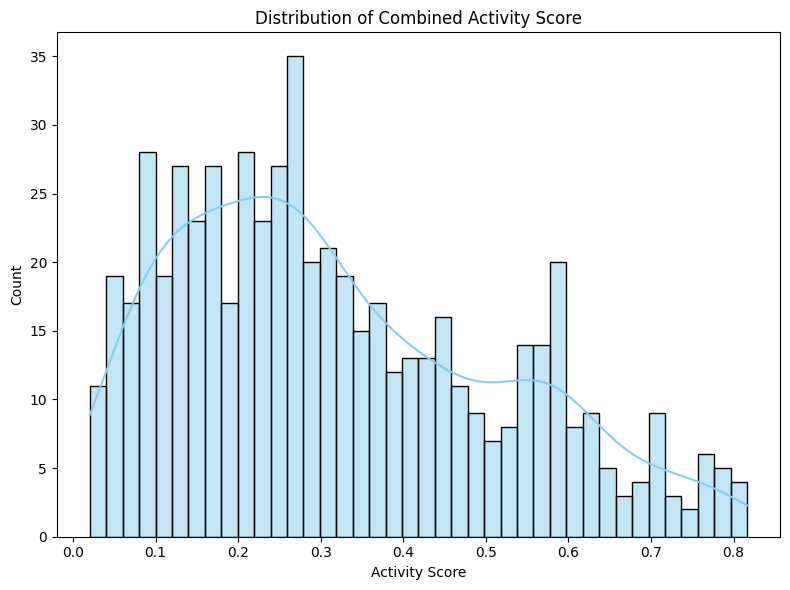

In [ ]:
import pandas as pd

# Load the features CSV
df = pd.read_csv('/content/drive/MyDrive/Freq_shifted/data/features_extended.csv')

# Verify the required columns are present
print(df.columns.tolist())

# Normalize BI and Event Density
df['bi_norm'] = (df['bioacoustic_index'] - df['bioacoustic_index'].min()) / (df['bioacoustic_index'].max() - df['bioacoustic_index'].min())
df['event_density_norm'] = (df['event_density'] - df['event_density'].min()) / (df['event_density'].max() - df['event_density'].min())

# Compute the combined activity score
df['activity_score'] = (df['bi_norm'] + df['event_density_norm']) / 2

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df['activity_score'], bins=40, kde=True, color='skyblue')
plt.title('Distribution of Combined Activity Score')
plt.xlabel('Activity Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Selected Activity Score Threshold (75th percentile): 0.4095


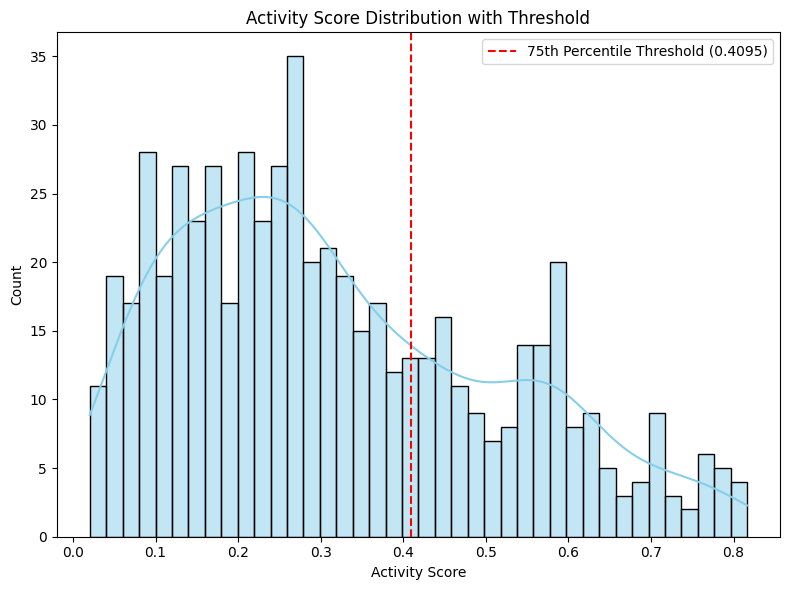

In [ ]:
# Calculate the 75th percentile threshold
threshold = df['activity_score'].quantile(0.75)
print(f"Selected Activity Score Threshold (75th percentile): {threshold:.4f}")

#Visualize the Threshold on the Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['activity_score'], bins=40, kde=True, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'75th Percentile Threshold ({threshold:.4f})')
plt.title('Activity Score Distribution with Threshold')
plt.xlabel('Activity Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Assign Activity Labels based on threshold
df['activity_label'] = df['activity_score'].apply(lambda x: 'High' if x >= threshold else 'Low')

#Saving the labelled
df.to_csv('/content/drive/MyDrive/Freq_shifted/data/labeled_features.csv', index=False)

try:
  files.download('/content/drive/MyDrive/Freq_shifted/data/labeled_features.csv')
  print(f"'/content/drive/MyDrive/Freq_shifted/data/labeled_features.csv' downloaded successfully.")
except FileNotFoundError:
  print(f"Error: The file '{features_csv_path}' was not found.")
except Exception as e:
  print(f"An error occurred during download: {e}")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'/content/drive/MyDrive/Freq_shifted/data/features_extended.csv' downloaded successfully.


# **Unsupervised Learning Approach**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report

# Load the labeled dataset
labeled_features = pd.read_csv('/content/drive/MyDrive/Freq_shifted/data/labeled_features.csv')

# Select the core features to cluster on
features = ['bioacoustic_index', 'event_density']
X = labeled_features[features].values

# Standardize
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)

# PCA to 2 dimensions (for clustering and visualization)
pca = PCA(n_components=2, random_state=42).fit(X_std)
X_pca = pca.transform(X_std)
labeled_features[['pc1', 'pc2']] = X_pca

# K-Means clustering (k=2)
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_pca)
labeled_features['cluster'] = kmeans.labels_

# Map clusters to High/Low by comparing mean activity_score
cluster_means = labeled_features.groupby('cluster')['activity_score'].mean()
# cluster with higher mean → “High”
high_cluster = cluster_means.idxmax()
labeled_features['cluster_label'] = labeled_features['cluster'].apply(lambda c: 'High' if c == high_cluster else 'Low')

Adjusted Rand Index between threshold and clustering labels: 0.543
Confusion Matrix (cluster vs threshold):
[[365  76]
 [  0 147]]

Classification Report (cluster vs threshold):
              precision    recall  f1-score   support

         Low       1.00      0.83      0.91       441
        High       0.66      1.00      0.79       147

    accuracy                           0.87       588
   macro avg       0.83      0.91      0.85       588
weighted avg       0.91      0.87      0.88       588



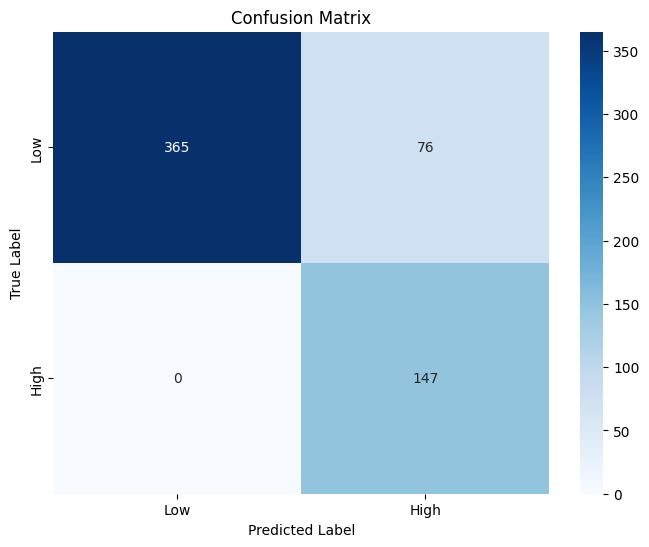

In [ ]:
# Compare cluster_label vs threshold-based activity_label
y_true = labeled_features['activity_label'].map({'Low':0, 'High':1})
y_pred = labeled_features['cluster_label'].map({'Low':0, 'High':1})

# Compute Adjusted Rand Index (how similar the two labelings are)
ari = adjusted_rand_score(y_true, y_pred)
print(f"Adjusted Rand Index between threshold and clustering labels: {ari:.3f}")

# Confusion matrix & classification report
print("Confusion Matrix (cluster vs threshold):")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report (cluster vs threshold):")
print(classification_report(y_true, y_pred, target_names=['Low', 'High']))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 10. (Optional) Save comparison
# df[['filename','activity_label','cluster_label']].to_csv(
#     '/content/drive/MyDrive/Freq_shifted/data/label_comparison.csv',
#     index=False
# )

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Paths
all_audio_dir = '/content/drive/MyDrive/Freq_shifted/data'
high_dir      = '/content/drive/MyDrive/Freq_shifted/high_activity'
low_dir       = '/content/drive/MyDrive/Freq_shifted/low_activity'

# Create output directories if they don't exist
os.makedirs(high_dir, exist_ok=True)
os.makedirs(low_dir, exist_ok=True)

# Valid audio extensions
audio_exts = {'.wav', '.mp3', '.flac', '.ogg'}

# Define consensus subset (where threshold and cluster labels agree)
consensus = labeled_features[labeled_features['activity_label'] == labeled_features['cluster_label']].copy()

# Train Random Forest on consensus subset
X = consensus[['bioacoustic_index', 'event_density']]
y = consensus['activity_label'].map({'Low': 0, 'High': 1})
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on non-consensus subset
non_consensus = labeled_features[labeled_features['activity_label'] != labeled_features['cluster_label']].copy()
X_non = non_consensus[['bioacoustic_index', 'event_density']]
preds = clf.predict(X_non)
non_consensus['predicted_label'] = pd.Series(preds).map({0: 'Low', 1: 'High'})

# Combine final labels
consensus['final_label'] = consensus['activity_label']
non_consensus['final_label'] = non_consensus['predicted_label']
final_df = pd.concat([consensus, non_consensus], ignore_index=True)

# Move audio files into respective folders (only audio files)
for _, row in final_df.iterrows():
    fn = row['filename']
    # Only process if extension is in our audio list
    if os.path.splitext(fn)[1].lower() not in audio_exts:
        continue

    src = os.path.join(all_audio_dir, fn)
    if not os.path.isfile(src):
        continue

    dest_dir = high_dir if row['final_label'] == 'High' else low_dir
    shutil.copy(src, os.path.join(dest_dir, fn))

print(f"Files moved: High = {len(final_df[final_df['final_label']=='High'])}, "
      f"Low = {len(final_df[final_df['final_label']=='Low'])}")

Files moved: High = 163, Low = 367


In [ ]:
# Paths (ensure these are correct after mounting your drive)
dataset_dir   = '/content/drive/MyDrive/Freq_shifted/dataset'
final_csv     = os.path.join(dataset_dir, 'final_labels.csv')

# Create the dataset directory
os.makedirs(dataset_dir, exist_ok=True)

# Save the final DataFrame to CSV
final_df.to_csv(final_csv, index=False)
print(f"Final labels CSV saved to: {final_csv}")
try:
  files.download(final_csv)
  print(f"'final csv' downloaded successfully.")
except FileNotFoundError:
  print(f"Error: The file '{features_csv_path}' was not found.")
except Exception as e:
  print(f"An error occurred during download: {e}")

# Move high/low activity folders under the dataset directory
for folder in [high_dir, low_dir]:
    if os.path.isdir(folder):
        dest = os.path.join(dataset_dir, os.path.basename(folder))
        # Remove any existing destination folder first
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.move(folder, dest)
        print(f"Moved '{folder}' to '{dest}'")


Final labels CSV saved to: /content/drive/MyDrive/Freq_shifted/dataset/final_labels.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'final csv' downloaded successfully.


In [ ]:
# Check the number of files in the high and low activity folders
print("\nChecking number of files in high_activity and low_activity folders:")
if os.path.isdir(os.path.join(dataset_dir, 'high_activity')):
    high_count = len([name for name in os.listdir(os.path.join(dataset_dir, 'high_activity')) if os.path.isfile(os.path.join(dataset_dir, 'high_activity', name))])
    print(f"Number of files in high_activity: {high_count}")
else:
    print("high_activity directory not found.")

if os.path.isdir(os.path.join(dataset_dir, 'low_activity')):
    low_count = len([name for name in os.listdir(os.path.join(dataset_dir, 'low_activity')) if os.path.isfile(os.path.join(dataset_dir, 'low_activity', name))])
    print(f"Number of files in low_activity: {low_count}")
else:
    print("low_activity directory not found.")


Checking number of files in high_activity and low_activity folders:
Number of files in high_activity: 163
Number of files in low_activity: 425
